# Calculate a subject-to-subject similarity matrix for SPSQ-SF questionnaire scores

https://naturalistic-data.org/content/Intersubject_RSA.html#calculate-behavioral-similarity

Load modules

In [2]:
import os
import glob
from pathlib import Path

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp, zscore
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

%matplotlib inline

In [3]:
data_dir = '/project/3013104.01/analysis/'
os.chdir(data_dir)

In [16]:
questionnaire_data = pd.read_csv(os.path.join(data_dir, 'SPSQ-24_all.csv'))
questionnaire_data.head()

,subject,as_SPS13_emotionally_touched_music_art,as_SPS29_notice_subtle_touching_tones_music,as_SPS31_very_movedy_nice_work_of_art,SPSQ_as,ep_SPS02_nervous_to_many_things_at_once,ep_SPS24_rushed_too_much_little_time,ep_SPS28_upset_when_people_ask_many_things_at_once,SPSQ_ep,sa_SPS03_see_sad_eyes_behind_smile,...,sd_SPS25_suffer_bright_light,SPSQ_sd,ss_SPS14_immediately_feel_mouth_throat_drier,ss_SPS15_hardly_visible_details_attract_attention,ss_SPS21_quickly_aware_changes_body,ss_SPS23_notice_faints_smells,SPSQ_ss,SPSQ_sum,SPSQ_pos,SPSQ_neg
0,subject-0001,1,1,1,3,1,1,4,6,1,...,1,7,7,6,4,7,24,79,66,13
1,subject-0003,6,6,6,18,1,3,4,8,1,...,4,20,4,6,6,6,22,125,97,28
2,subject-0004,4,4,4,12,4,4,4,12,4,...,3,13,4,3,4,4,15,103,78,25
3,subject-0005,3,5,2,10,3,6,4,13,6,...,5,21,6,6,5,3,20,123,89,34
4,subject-0006,6,5,4,15,5,4,4,13,6,...,5,19,6,4,5,4,19,126,94,32


Check distributions of each variable of interest. If they are not normally distributed, then convert to ranks. If they are normally distributed, then do not convert to ranks.

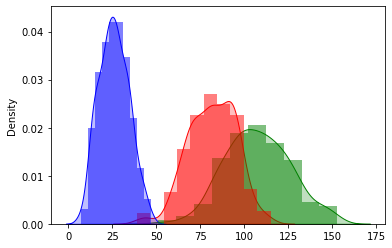

In [17]:
# Separate DataFrames for each variable
SPSQ_sum_data = questionnaire_data['SPSQ_sum']
SPSQ_pos_data = questionnaire_data['SPSQ_pos']
SPSQ_neg_data = questionnaire_data['SPSQ_neg']

# Convert the pandas Series to numpy arrays
SPSQ_sum_data = SPSQ_sum_data.values
SPSQ_pos_data = SPSQ_pos_data.values
SPSQ_neg_data = SPSQ_neg_data.values

# Plot the histograms using numpy.histogram
plt.figure()
plt.hist(SPSQ_sum_data, color='green', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_pos_data, color='red', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_neg_data, color='blue', bins=10, alpha=0.5, density=True)

# Plot the KDEs using seaborn kdeplot
sns.kdeplot(SPSQ_sum_data, color='green', fill=True)
sns.kdeplot(SPSQ_pos_data, color='red', fill=True)
sns.kdeplot(SPSQ_neg_data, color='blue', fill=True)

plt.show()

In [18]:
# Convert DataFrame to z-scores
#questionnaire_data_z = questionnaire_data.copy()  # Create a copy of the original DataFrame

# Iterate over columns (except the first one)
#for column in questionnaire_data_z.columns[1:]:
#    questionnaire_data_z[column] = zscore(questionnaire_data_z[column])

#questionnaire_data_z.head()

#questionnaire_data_z.to_csv('SPSQ-24_all_z.csv', index=False)

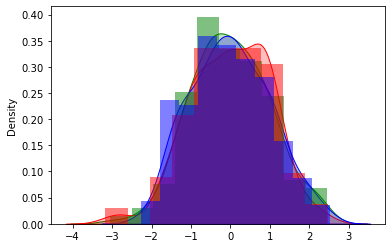

In [19]:
# Separate DataFrames for each variable
#SPSQ_sum_data = questionnaire_data_z['SPSQ_sum']
#SPSQ_pos_data = questionnaire_data_z['SPSQ_pos']
#SPSQ_neg_data = questionnaire_data_z['SPSQ_neg']

# Convert the pandas Series to numpy arrays
#SPSQ_sum_data = SPSQ_sum_data.values
#SPSQ_pos_data = SPSQ_pos_data.values
#SPSQ_neg_data = SPSQ_neg_data.values

# Plot the histograms using numpy.histogram
#plt.figure()
#plt.hist(SPSQ_sum_data, color='green', bins=10, alpha=0.5, density=True)
#plt.hist(SPSQ_pos_data, color='red', bins=10, alpha=0.5, density=True)
#plt.hist(SPSQ_neg_data, color='blue', bins=10, alpha=0.5, density=True)

# Plot the KDEs using seaborn kdeplot
#sns.kdeplot(SPSQ_sum_data, color='green', fill=True)
#sns.kdeplot(SPSQ_pos_data, color='red', fill=True)
#sns.kdeplot(SPSQ_neg_data, color='blue', fill=True)

#plt.show()

## Calculate questionnaire response similarity

### Euclidean distance (i.e., nearest neighbor)

#### Specify which questionnaire items to use

In [5]:
sum_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art', 'ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells'] # 24 items

positive_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells'] # 17 items

negative_score = ['ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light'] # 7 items

#### Calculate distance and then similarity matrices

To convert Euclidean distance to similarities, the formula for similarity or affinity can be used (i.e., the "inverse distance" or "inverse proportionality" approach). In general, the more similar two points are, the closer their distance should be to zero. Therefore, the inverse of the Euclidean distance can be used to obtain a similarity score. Given two points, A and B, with their Euclidean distance d_euc(A, B), the distance can be converted to similarity (sim) so that sim(A,B)=1/(1+d_euc(A,B)). This makes interpetation more straightforward because positive similarity values will then reflect a higher representational similarity between brain and questionnaire. This approach, however, left outliers when transforming distance to similarity, requiring an alternative aproach.

In [26]:
#import pandas as pd
#import numpy as np
#from scipy.spatial.distance import cdist # Computes distance between each pair of the two collections of inputs
#import os

# Read the CSV file
#data = pd.read_csv(os.path.join(data_dir, 'SPSQ-24_all.csv'), header=0, index_col=0)

# Select columns from the data depending on whatever dimension
#scores_df = data[negative_score]

# Calculate Euclidean distance matrix
#euclidean_distance_matrix = cdist(scores_df, scores_df, metric='euclidean')

# Export Euclidean distance matrix to csv
#euclidean_distance_df = pd.DataFrame(euclidean_distance_matrix, index=scores_df.index, columns=scores_df.index)
#euclidean_distance_df.to_csv('similarity_matrices_spsq/SPSQ-24_all/distance_matrix_negative_score.csv', index=True)

# Convert the Euclidean distances to similarities 
#euclidean_distance_similarity = 1 / (1 + euclidean_distance_matrix)

# Convert the similarity matrix to a pandas DataFrame
#similarity_matrix_df = pd.DataFrame(euclidean_distance_similarity, index=scores_df.index, columns=scores_df.index)

# Export similarity matrix to csv
#similarity_matrix_df.to_csv('similarity_matrices_spsq/SPSQ-24_all/similarity_matrix_negative_score.csv', index=True)

Rank-Based Transformations: Instead of directly transforming the distances into similarities, use rank-based transformation. Rank-based methods assign ranks to distances and then transform the ranks into similarities. Rank-based approaches are often more robust to the underlying distribution of the data. The following uses the Spearman rank correlation coefficient to convert ranks into similarities.

In [9]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist # Computes distance between each pair of the two collections of inputs
from scipy.stats import spearmanr
import os

# Read the CSV file
data = pd.read_csv(os.path.join(data_dir, 'SPSQ-24_all.csv'), header=0, index_col=0)

# Select columns from the data depending on whatever dimension
scores_df = data[sum_score]

# Calculate Euclidean distance matrix
euclidean_distance_matrix = cdist(scores_df, scores_df, metric='euclidean')

# Export Euclidean distance matrix to csv
euclidean_distance_df = pd.DataFrame(euclidean_distance_matrix, index=scores_df.index, columns=scores_df.index)
euclidean_distance_df.to_csv('similarity_matrices_spsq/SPSQ-24_all/distance_matrix_sum_score.csv', index=True)

# Rank the distances
ranks_distances = np.argsort(euclidean_distance_matrix, axis=1).argsort()

# Calculate Spearman rank correlation
spearman_rho, _ = spearmanr(ranks_distances, axis=1)

# Convert to similarity
spearman_similarity = 1 - abs(spearman_rho)

# Set diagonal elements to 1.0
np.fill_diagonal(spearman_similarity, 1.0)

# Convert the similarity matrix to a pandas DataFrame
similarity_matrix_df = pd.DataFrame(spearman_similarity, index=scores_df.index, columns=scores_df.index)

# Export similarity matrix to csv
similarity_matrix_df.to_csv('similarity_matrices_spsq/SPSQ-24_all/similarity_matrix_sum_score.csv', index=True)

### Next step: Intersubject Representational Similarity Analysis (IS-RSA)